In [4]:
import pandas as pd
import re
import datetime as dt

filepath = '../Downloads/'
delimiter = '____________________________________________________________\n'
files = [
    'ProQuestDocuments-2021-10-22_400-476.txt', 
    'ProQuestDocuments-2021-10-22_301-400.txt',
    'ProQuestDocuments-2021-10-22_201-300.txt',
    'ProQuestDocuments-2021-10-22_101-200.txt',
    'ProQuestDocuments-2021-10-22_1-100.txt',
]
stories = []
for file in files:
    with open(filepath + file) as f:
        story = ''
        for line in f.readlines():
            if line != delimiter:
                story += line + '\n'
            else:
                if len(story) > 1:
                    stories.append(story)
                story = ''
print(len(stories))

476


In [5]:
stories_full_text = [re.findall('Full text: .+', s)[0] for s in stories]
stories_people = [re.findall('People: .+', s)[0] for s in stories]
stories_timestamps = [
    re.findall('Publication date: [a-zA-Z]+ [0-9a-zA-Z]+..+', s)[0][-12:].strip() 
    for s in stories
]

def fix_day_of_month(ts):
    ts_1 = re.findall('[0-9A-Za-z \,]+', ts)[0]
    try:
        day_of_month = ts_1.split(' ')[1].strip()
        if len(day_of_month) == 2:
            day_of_month = '0' + day_of_month
        ts = ts_1.split(' ')[0] + ' ' + day_of_month  + ' '+ ' '.join(ts_1.split(' ')[2:])
        return ts
    except IndexError:
        ts = ts.split(' ')[1] + ' 01, ' + ts.split(' ')[-1]
        return ts 
    
stories_dt = [dt.datetime.strptime(fix_day_of_month(s), '%b %d, %Y') for s in stories_timestamps]

In [6]:
df3 = pd.DataFrame({'ts': stories_dt, 'full_text': stories_full_text})
df3.to_csv('us_weekly_full_text.tsv', sep='\t')

In [7]:
df3 = pd.read_csv('../Downloads/us_weekly_coded - us_weekly_full_text.tsv', sep='\t')
df3['ts'] = pd.to_datetime(df3['ts'])

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

txts = [] 
txts = df2['quote'].tolist() + df3['full_text'].tolist() 
txts = [re.sub('[0-9]+', ' ', t) for t in txts] 
vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.5, stop_words='english') 
X = vectorizer.fit_transform(txts) 
scores = {v: np.mean(X[:, idx]) for idx, v in enumerate(vectorizer.get_feature_names())}

def get_score_wrapper(v,idx, scores, X): 
    try: 
        return np.mean(X[:, idx]) / scores[v] 
    except KeyError: 
        if np.mean(X[:, idx]) < 0.0001: 
            return 0.0 
        else: 
            return np.mean(X[:, idx])

documents = {} 
features = {} 
for name, gr in grouped_df2: 
    document = [] 
    for c, txt in zip(df3['code'], df3['full_text']): 
        if name in c: 
            document.append(txt) 
    document.extend(gr['quote'].tolist()) 
    document = [re.sub('[0-9]+', ' ', t) for t in document] 
    vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.5, stop_words='english') 
    X = vectorizer.fit_transform(document) 
    feats = sorted(
        [
            (v, get_score_wrapper(v, idx, scores, X)) 
            for idx, v in enumerate(vectorizer.get_feature_names())
        ], key=lambda b: b[1], reverse=True
    )[0:50] 
    features[name] = [v[0] for v in feats] 
    documents[name] = document


In [41]:
import pandas as pd
def word_find_score(txt, vocab):
    score = 0
    for word in vocab:
        if word.lower() in txt.lower():
            score += 1
    return score

df4 = pd.read_csv('britney_twitter.tsv', sep='\t')
content_britney = df4[['created_at', 'text']].dropna().sort_values('created_at')
content_britney['created_at'] = pd.to_datetime(content_britney['created_at'], errors='coerce', utc=True)
content_britney = content_britney.dropna()
for name, voc in features.items():
    content_britney[name + '_score'] = content_britney['text'].apply(lambda b: word_find_score(b, voc))

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3056: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [42]:
def round_to_nearest_monday(ts):
    return ts + dt.timedelta(days=(7 - ts.weekday()))
content_britney['ts_week'] = content_britney['created_at'].apply(round_to_nearest_monday)

In [87]:
def zero_if_too_small(x):
    if x < 10:
        return 0
    else:
        return x
titles = [k for k in features.keys()]
content_britney['max_title'] = content_britney[[title + '_score' for title in titles]].idxmax(axis=1)

names_to_dts = {}
for f in titles:
    res = {}
    for mt, tw, ns in zip(
        content_britney['max_title'], 
        content_britney['ts_week'], 
        content_britney[name + '_score']
    ):
        if f + '_score' == mt and ns > 1:
            if tw in res:
                res[tw] += ns
            else:
                res[tw] = ns
    names_to_dts[f] = [(k, v) for k, v in res.items()]
    

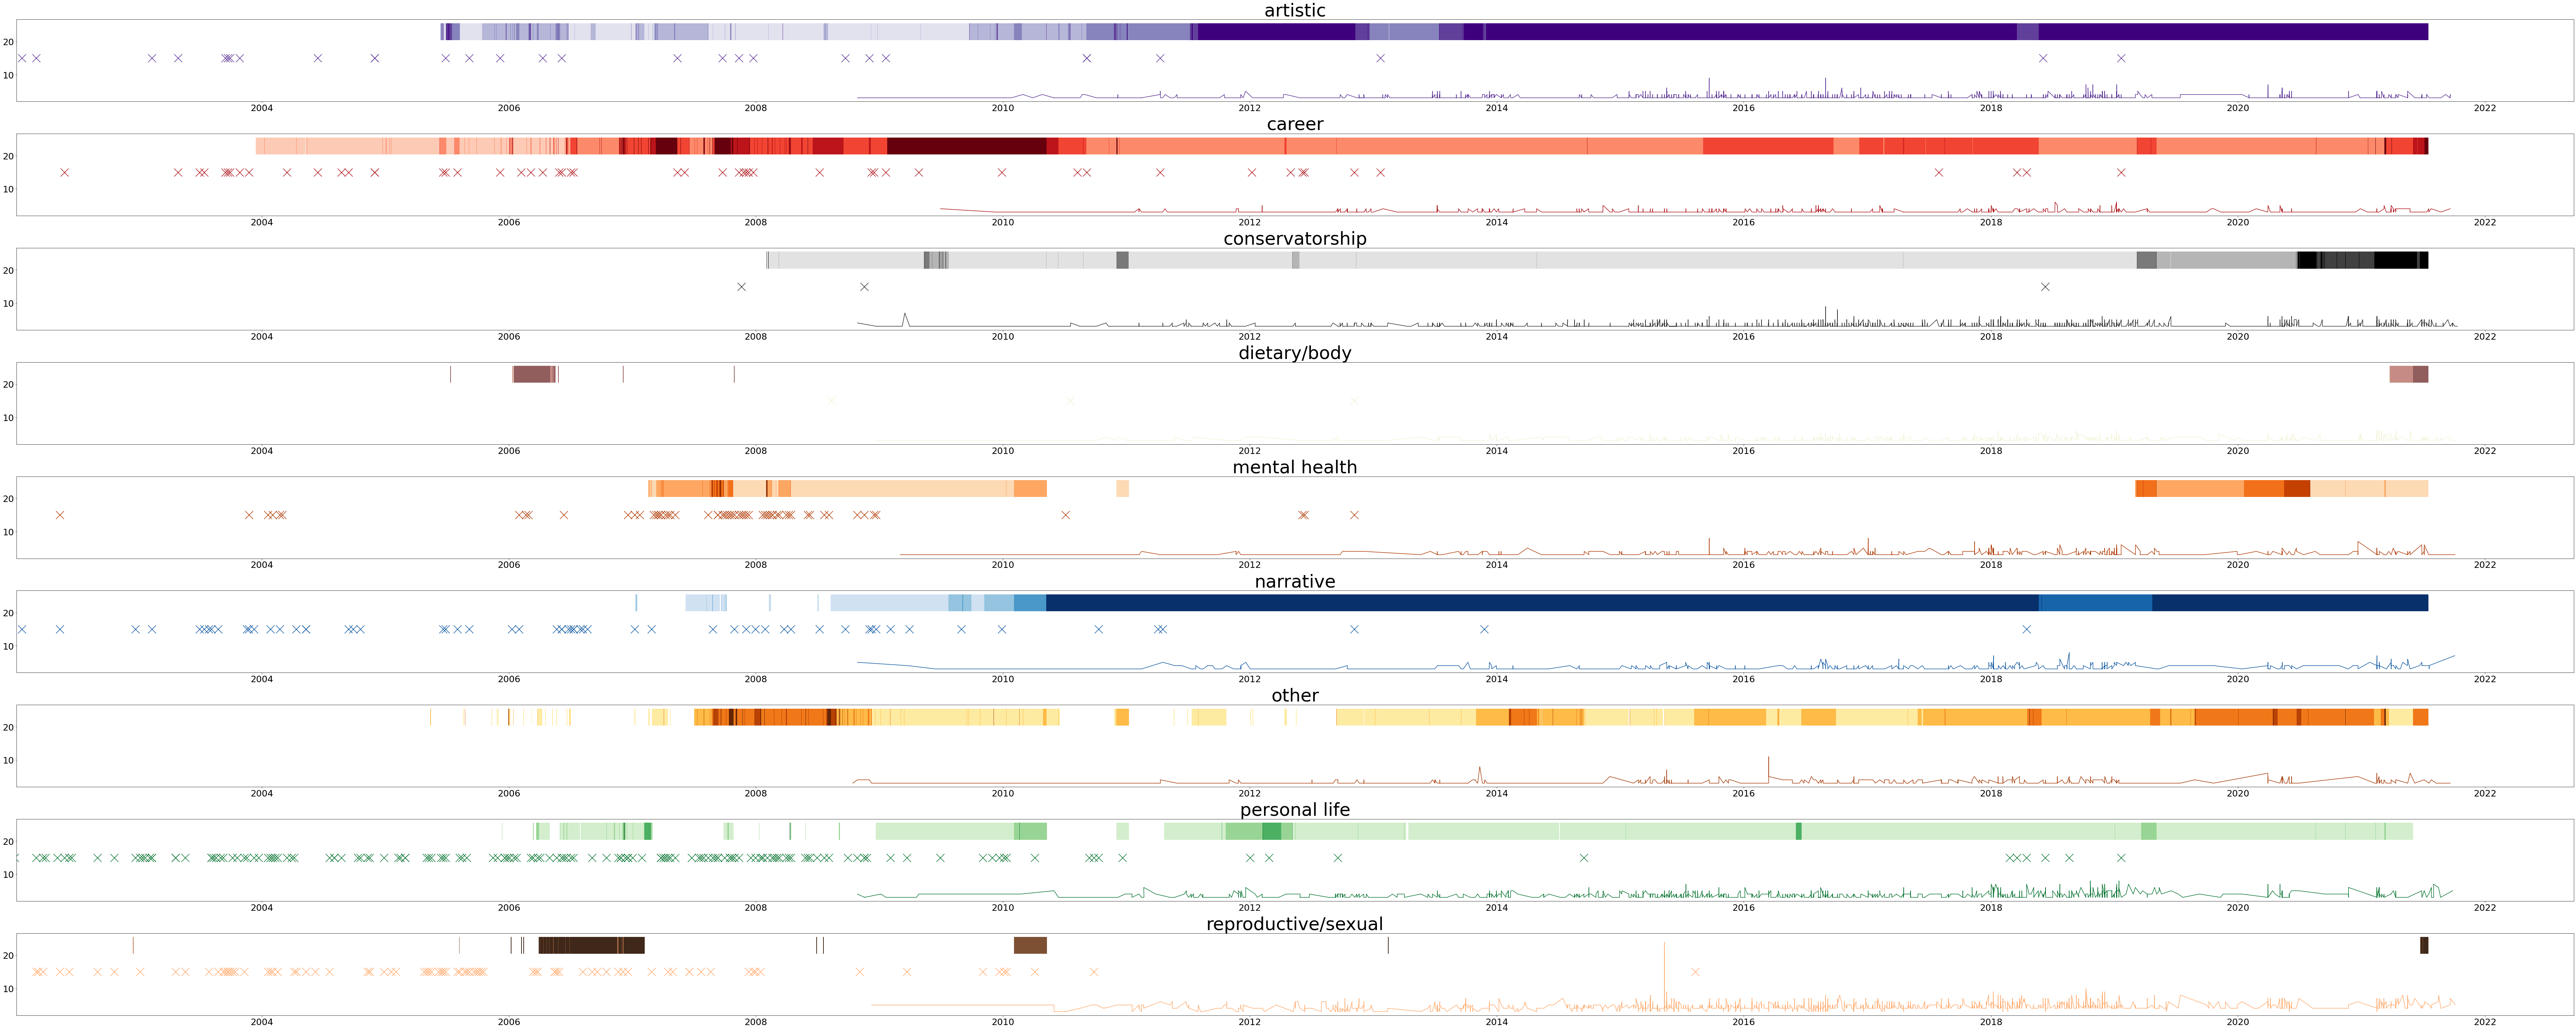

In [88]:
def get_timestamps_where_keyword_appeared(stories_full_text, stories_dt, keywords):
    dts = []
    for ft, ts in zip(stories_full_text, stories_dt):
        for keyword in keywords:
            if keyword.lower() in ft.lower():
                dts.append(ts)
                continue
    return dts


def get_topic_in_codes(code_list, timestamps, topic):
    dts = []
    for c, ts in zip(code_list, timestamps):
        if topic in c:
            dts.append(ts)
    return dts

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

df2 = pd.read_csv('~/Downloads/wikipedia_quotes_expanded_keywords - control_quotes_expanded_wikipedia.tsv', sep='\t')
df2['simplified_theme'] = df2['category'].apply(lambda b: b.split(',')[0])
grouped_df2 = df2.groupby('simplified_theme')
# cmap = cm.get_cmap('tab10')
cmaps = {
    'artistic': cm.get_cmap('Purples'), 
    'career': cm.get_cmap('Reds'), 
    'other': cm.get_cmap('YlOrBr'),
    'personal life': cm.get_cmap('Greens'),
    'mental health': cm.get_cmap('Oranges'),
    'narrative': cm.get_cmap('Blues'),
    'reproductive/sexual': cm.get_cmap('copper'),
    'dietary/body': cm.get_cmap('pink'),
    'conservatorship': cm.get_cmap('Greys')
}
plt.rcParams["figure.figsize"] = (100,40)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

fig, ax = plt.subplots(len(titles), sharex=True, sharey=True)

i = 0
names = []
poo = 0
for name, gr in grouped_df2:
    i = 0.0
    names.append(name)
    z = get_topic_in_codes(df3['code'], df3['ts'], name)
    ax[poo].scatter(z, (15.0 ) * np.ones(len(z)), s=500,color=cmaps[name](0.85), marker='x')
    ax[poo].plot([n[0] for n in names_to_dts[name]], [1.0 + i + n[1] for n in names_to_dts[name]], color=cmaps[name](0.85))
    dt_values = {}
    for idx, row in gr.iterrows():
        for date in pd.date_range(dt.datetime.strptime(str(row[1]), '%Y%m%d'), dt.datetime.strptime(str(row[2]), '%Y%m%d')):
            if date in dt_values:
                dt_values[date] = dt_values[date] + 1
            else:
                dt_values[date] = 1
    
#     for k, v in dt_values.items():
#         plt.plot([k, k], [i, i + 0.25 * v], linewidth=10.0, color=cmap((i / 2.0) / len(grouped_df2)))

        
    tups = []
    colors = []
    for k, v in dt_values.items():
        tups.append((k, 1))
        colors.append(cmaps[name](v / 5.0))
    ax[poo].broken_barh(tups, yrange=(0.5 + i + 20.0, 5.0), color=colors)
    ax[poo].set_title(name, fontsize=50)
    ax[poo].tick_params(axis='both', which='both', labelsize=25, labelbottom=True)
    poo += 1
    i += 30.0
fig.tight_layout()



plt.show()